Simple Altro from Kevin

In [5]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/Documents/REx Lab/TinyMPC/julia/altro_rocket/Project.toml`


In [6]:
using LinearAlgebra
using Printf
import ForwardDiff as FD
using Plots

In [7]:
## -------------------THIS IS ALL ALTRO-------------------------------
function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du
end
function term_cost_expansion(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ)
    # backwards pass for Altro
    # P - vector of cost to go quadratic terms (matrices)
    # p - vector of cost to go linear terms (vectors)
    # K - vector of feedback gain matrices (matrices)
    # d - vector of feedforward controls (vectors)
    N = params.N
    ΔJ = 0.0

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params,X[N])

    if params.ncx > 0
        # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])

        # add these into the CTG p and P
        p[N]  += ∇hx'*(μx[N] + ρ*(mask * hxv))
        P[N]  += ρ*∇hx'*mask*∇hx
    end
    if params.ncg > 0
        # add AL terms for goal constraint
        hxv = X[N] - params.Xref[N]
        ∇hx = diagm(ones(params.nx))

        # add these into the CTG p and P
        p[N]  += ∇hx'*(λ + ρ*hxv)
        P[N]  += ρ*∇hx'∇hx
    end
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1

        # dynamics jacobians
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        # cost expansion
        Jxx,Jx,Juu,Ju = stage_cost_expansion(params,X[k],U[k],k)
        if params.ncu > 0
            # control constraints
            huv = ineq_con_u(params,U[k])
            mask = eval_mask(μ[k],huv)
            ∇hu = ineq_con_u_jac(params,U[k])
            Ju  += ∇hu'*(μ[k] + ρ*(mask * huv))
            Juu += ρ*∇hu'*mask*∇hu
        end
        if params.ncx > 0
        # state constraints
        hxv = ineq_con_x(params,X[k])
        mask = eval_mask(μx[k],hxv)
        ∇hx = ineq_con_x_jac(params,X[k])
        Jx  += ∇hx'*(μx[k] + ρ*(mask * hxv))
        Jxx += ρ*∇hx'*mask*∇hx
        end
        # Q expansion
        gx = Jx + A'*p[k+1]
        gu = Ju + B'*p[k+1]

        # # un regularized
        # Gxx = Jxx + A'*P[k+1]*A
        # Guu = Juu + B'*P[k+1]*B
        # Gux = B'*P[k+1]*A

        # regularized
        Gxx = Jxx + A'*(P[k+1] + reg*I)*A
        Guu = Juu + B'*(P[k+1] + reg*I)*B
        Gux = B'*(P[k+1] + reg*I)*A

        # Calculate Gains
        F = cholesky(Symmetric(Guu))
        d[k] = F\gu
        K[k] = F\Gux

        # Cost-to-go Recurrence (PSD stabilizing version)
        P[k] = Jxx + K[k]'*Juu*K[k] + (A-B*K[k])'*P[k+1]*(A-B*K[k])
        p[k] = Jx - K[k]'*Ju + K[k]'*Juu*d[k] + (A - B*K[k])'*(p[k+1] - P[k+1]*B*d[k])
        ΔJ += gu'*d[k]
    end

    return ΔJ
end
function trajectory_AL_cost(params,X,U,μ,μx,ρ,λ)
    N = params.N
    J = 0.0
    for k = 1:N-1
        J += stage_cost(params,X[k],U[k],k)
        if params.ncu > 0
            # AL terms for ineq_con_u
            huv = ineq_con_u(params,U[k])
            mask = eval_mask(μ[k],huv)
            J += dot(μ[k],huv) + 0.5*ρ*huv'*mask*huv
        end
        if params.ncx > 0
        # AL terms for ineq_con_x
        hxv = ineq_con_x(params,X[k])
        mask = eval_mask(μx[k],hxv)
        J += dot(μx[k],hxv) + 0.5*ρ*hxv'*mask*hxv
        end
    end
    if params.ncx > 0
    # AL terms for state constraint at last time step
    J += term_cost(params,X[N])
    hxv = ineq_con_x(params,X[params.N])
    mask = eval_mask(μx[params.N],hxv)
    J += dot(μx[params.N],hxv) + 0.5*ρ*hxv'*mask*hxv
    end
    if params.ncg > 0
    # AL terms for goal constraint
    hxv = X[N] - params.Xref[N]
    J += dot(λ,hxv) + 0.5*ρ*hxv'*hxv
    end
    return J
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; max_linesearch_iters = 20)

    N = params.N
    α = 1.0

    J = trajectory_AL_cost(params,X,U,μ,μx,ρ,λ)
    for i = 1:max_linesearch_iters

        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = U[k] - α*d[k] - K[k]*(Xn[k]-X[k])
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
        Jn = trajectory_AL_cost(params,Xn,Un,μ,μx,ρ,λ)

        # linesearch
        if Jn < J
            X .= Xn
            U .= Un
            return Jn, α
        else
            α *= 0.5
        end
    end

    @warn "forward pass failed, adding regularization"
    α = 0.0
    return J, α
end
function update_reg(reg,reg_min,reg_max,α)
    if α == 0.0
        if reg == reg_max
            error("reached max reg")
        end
        return min(reg_max,reg*10)
    end
    if α == 1.0
        return max(reg_min,reg/10)
    end
    return reg
end
function calc_max_d(d)
    dm = 0.0
    for i = 1:length(d)
        dm = max(dm,norm(d[i]))
    end
    return dm
end
function eval_mask(μv,huv)
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = μv[i] > 0 || huv[i] > 0
    end
    mask
end

function iLQR(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything

    # keep track of trajectories for each iterate
    Xhist=[deepcopy(X) for i = 1:1000]

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    Xhist[1] .= X


    reg_min = 1e-6
    reg = reg_min
    reg_max = 1e2

    μ = params.μ

    μx = params.μx

    λ = params.λ

    for iter = 1:max_iters
        ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ)
        J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)

        Xhist[iter + 1] .= X

        reg = update_reg(reg,reg_min,reg_max,α)
        dmax = calc_max_d(d)
        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, dmax, α, reg,ρ)
        end
        if (α > 0) & (dmax<atol)
            # check convio
            convio = 0
            if params.ncu > 0
                # control constraints
                for k = 1:N-1
                    huv = ineq_con_u(params,U[k])
                    mask = eval_mask(μ[k],huv)

                    # update dual
                    μ[k] = max.(0,μ[k] + ρ*mask*huv)
                    convio = max(convio,norm(huv + abs.(huv),Inf))
                end
            end
            if params.ncx > 0
            # state constraints
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)

                # update dual
                μx[k] = max.(0,μx[k] + ρ*mask*hxv)
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
            end
            end
            if params.ncg > 0
            # goal constraint
            hxv = X[N] - params.Xref[N]
            λ .+= ρ*hxv
            convio = max(convio, norm(hxv,Inf))
            end
            @show convio
            if convio <1e-4
                @info "success!"
                return Xhist[1:(iter + 1)]
            end

            ρ *= ϕ
        end
    end
    @printf("iLQR failed")
end
## ----------------------ALTRO DONE --------------------------

iLQR (generic function with 1 method)

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    2.642e+04   4.10e+07   6.49e+02  1.0000    1.00e-06    1.00e+02
  2    1.708e+04   1.78e+04   1.11e+01  1.0000    1.00e-06    1.00e+02
  3    1.627e+04   1.20e+03   4.06e+00  1.0000    1.00e-06    1.00e+02
  4    1.549e+04   1.86e+03   4.55e+00  1.0000    1.00e-06    1.00e+02
  5    1.532e+04   3.37e+02   1.07e+00  1.0000    1.00e-06    1.00e+02
  6    1.532e+04   5.66e-01   7.83e-02  1.0000    1.00e-06    1.00e+02
convio = 0.15765177275669184
  7    1.534e+04   1.42e+02   1.54e+00  1.0000    1.00e-06    1.00e+03
  8    1.534e+04   4.57e-02   4.38e-02  1.0000    1.00e-06    1.00e+03
convio = 0.0737457300214741
  9    1.535e+04   7.77e+01   3.41e+00  1.0000    1.00e-06    1.00e+04
 10    1.535e+04   4.17e-03   1.21e-02  1.0000    1.00e-06    1.00e+04
convio = 0.006887571669150233
iter     J           ΔJ        |d|         α        reg         ρ
-

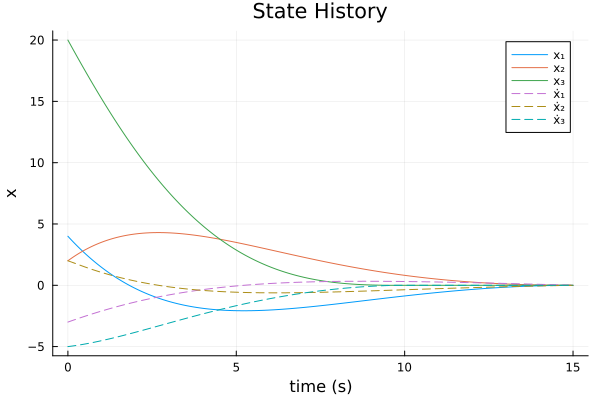

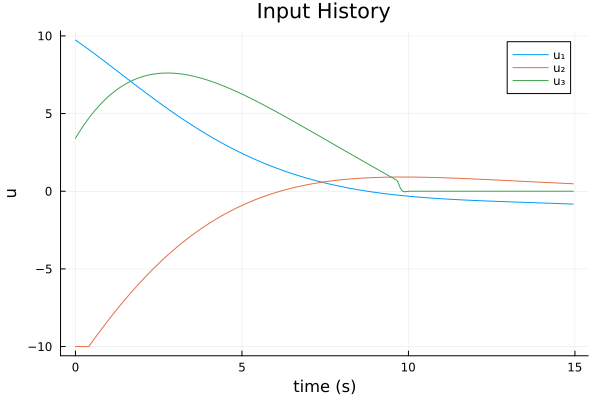

 13    1.535e+04   9.37e-01   2.63e-01  1.0000    1.00e-06    1.00e+06
 14    1.535e+04   1.26e-04   2.99e-03  1.0000    1.00e-06    1.00e+06
convio = 0.0002241144270360492
 15    1.535e+04   5.14e-01   1.69e-01  1.0000    1.00e-06    1.00e+07
 16    1.535e+04   6.03e-11   1.73e-06  1.0000    1.00e-06    1.00e+07
convio = 6.507243868750259e-5


┌ Info: success!
└ @ Main /Users/anoushkaalavill/Documents/REx Lab/TinyMPC/julia/altro_rocket/simple_altro.ipynb:267


In [8]:
# ---------------------ROCKET LANDING--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0;  
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f*0
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end

# here is the script
# Let's solve
# include("mpc_JuMP.jl")

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 10e-1*I(nx)
R = 1e-0*I(nu)
Qf = Q#100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*1
ncu = 2*nu*1
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e-2  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
Xhist = iLQR(params,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 100,verbose = true,ρ = 1e2, ϕ = 10.0)

function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))